In [5]:
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from datetime import date, datetime, timedelta
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from utils import *
from data_preperation import * 
from utils import *

In [2]:
#STEP 1: Read and Process Masurement Data
# Read 1 file per semester
def get_data():
    df0 = pd.read_csv("2015_S2.csv", sep = ";")
    df1 = pd.read_csv("2016_S1.csv", sep = ";")
    df2 = pd.read_csv("2016_S2.csv", sep = ";")
    df3 = pd.read_csv("2017_S1.csv", sep = ";")
    df4 = pd.read_csv("2017_S2.csv", sep = ";")
    df5 = pd.read_csv("2018_S1.csv", sep = ";")
    df6 = pd.read_csv("2018_S2.csv", sep = ";")
    df7 = pd.read_csv("2019_S1.csv", sep = ";")
    df8 = pd.read_csv("2019_S2.csv", sep = ";")

    data0 = pd.concat([df0, df1, df2, df3, df4, df5, df6, df7, df8], ignore_index=True)
    print('read csv semester csv files from 2015s2 to 2019s2')
    return data0


# Functions
# Convert scenario to one_hot
def scenario_one_hot(data, one_hot=False):
    # extract numeric data from scenario 'S1' to '1'
    data['scenario_num'] = (data['scenario'].str.extract('(\d+)')).astype(int)
    data.drop(['scenario'], axis=1, inplace=True)

    # add one-hot encoding to scenario:
    if one_hot:
        scenario = pd.get_dummies(data['scenario_num'], prefix='scenario', dummy_na=True)
        data1 = pd.concat([data, scenario], axis=1)
        return data1
    return data


# Make cyclical data into continuous data using cos & sin
def smooth_wind_dir(data):
    data['cos_wind_dir'] = np.cos(2 * np.pi * data['wind_dir'] / 360)
    data['sin_wind_dir'] = np.sin(2 * np.pi * data['wind_dir'] / 360)
    print('smooth wind direction')
    return data


def smooth_hour(data):
    # split '00h00' to two columns of numeric values
    hour = data['hour'].str.split(pat='h', expand=True)
    hour = hour.apply(pd.to_numeric, errors='coerce')

    # calculate minutes passed since 00h00
    hour['minutes'] = 60 * hour[0] + hour[1]
    hour['cos_hour'] = np.cos(2 * np.pi * hour['minutes'] / (60 * 24))
    hour['sin_hour'] = np.sin(2 * np.pi * hour['minutes'] / (60 * 24))

    # concat and update dataframe
    data = pd.concat([data, hour[['cos_hour', 'sin_hour']]], axis=1)
    print('smooth hour')
    return data


# Smooth date
def smooth_day(data):
    # Convert day & hour to date-time format
    data['datetime'] = data['day'].str.cat(data['hour'], sep=' ')
    data['datetime'] = pd.to_datetime(data['datetime'], format='%d/%m/%Y %Hh%M')
    data['day'] = pd.to_datetime(data['day'], format='%d/%m/%Y')
    data['hour'] = data['hour'].str.extract('(\d+)')
    data['hour'] = pd.to_numeric(data['hour'])

    # Calculate time delta since 1st entry
    data['day_delta'] = pd.to_numeric(data['day'] - data['day'][0])
    data['cos_day'] = np.cos(2 * np.pi * data['day_delta'] / (365))
    data['sin_day'] = np.sin(2 * np.pi * data['day_delta'] / (365))
    data.drop(['day_delta', 'day'], axis=1, inplace=True)

    print('smooth day')
    return data


# Generate new features:
# Generate daily features: daily min, max
def generate_daily(df):
    # group data into daily batches
    grouped = df.resample('D')
    min_speed = []
    max_speed = []
    min_hour = []
    max_hour = []

    for datetime, group in grouped:
        # find daily min & max
        s1 = group['speed'].min()
        s2 = group['speed'].max()
        # find the time of min & max speed
        h1 = group.loc[group['speed'] == s1]['hour'].values[0]
        h2 = group.loc[group['speed'] == s2]['hour'].values[0]

        min_speed.append(s1)
        max_speed.append(s2)
        min_hour.append(h1)
        max_hour.append(h2)

    # output new features as a dataframe
    start = df.index[0].date()
    end = df.index[-1].date()
    date_range = pd.date_range(start, end, freq='D')
    daily = pd.concat([pd.Series(min_speed), pd.Series(min_hour), pd.Series(max_speed), pd.Series(max_hour)], axis=1,
                      keys=['daily_min_speed', 'daily_min_hour', 'daily_max_speed', 'daily_max_hour'])
    daily.set_index(date_range, inplace=True)

    # #merge new features into dataframe: match with date
    df_out = pd.merge(df, daily, how='outer', left_index=True, right_index=True)
    # fill NaN values with same daily values
    df_out = df_out.fillna(method='ffill')

    print('generate daily features: %s' % (daily.columns.to_list()))
    return df_out


# Categorical features
def generate_season(df):
    df['season'] = 0
    df['month'] = df.index.month
    df.loc[df['month'].isin([12, 1, 2]), 'season'] = 1
    df.loc[df['month'].isin([3, 4, 5]), 'season'] = 2
    df.loc[df['month'].isin([6, 7, 8]), 'season'] = 3
    df.loc[df['month'].isin([9, 10, 11]), 'season'] = 4
    df.drop(['month'], axis=1, inplace=True)
    print('generate seasonality categorical feature')
    return df


def generate_day_night(df):
    df['day'] = 0
    df['night'] = 0
    df.loc[df['hour'].isin([8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]), 'day'] = 1
    df.loc[df['hour'].isin([0, 1, 2, 3, 4, 5, 6, 7, 19, 20, 21, 22, 23]), 'night'] = 1
    print('generate day/night categorical feature')
    return df


# Function to prepare data using above functions
def prepare_data(one_hot=False):
    # Interpolate missing values
    data0 = get_data()
    data = data0.interpolate()
    data = data.fillna(method='ffill')

    # scenario to one-hot encoding
    data = scenario_one_hot(data, one_hot)

    # smooth wind_dir, hour, and day using cos & sin function
    data = smooth_wind_dir(data)
    data = smooth_hour(data)
    data = smooth_day(data)
    data.drop(['details'], axis=1, inplace=True)
    data.index = data['datetime']
    data = data.interpolate()

    # averaging 15min data to hourly
    data = data.resample('H').mean()
    data = data.round({'scenario_num': 0})

    # generate daily max & min wind speed features
    data = generate_daily(data)

    # generate seasonal, day/night categorical features
    data = generate_season(data)
    data = generate_day_night(data)

    return data

data = prepare_data()

read csv semester csv files from 2015s2 to 2019s2
smooth wind direction
smooth hour
smooth day
generate daily features: ['daily_min_speed', 'daily_min_hour', 'daily_max_speed', 'daily_max_hour']
generate seasonality categorical feature
generate day/night categorical feature


In [4]:
#STEP 2: Merge with forecast 
#read csv: 
def get_forecast():
    df= pd.read_csv('weather_forecast_data_for_cynthia.csv', sep = ";")
    print('reading forecast data')
    return df 

#convert to datetime index
def convert_datetime(df):
    df['f_date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M') #future_date
    df['cycle']=df['cycle'].str.replace('h', ':00', regex=True)
    df['p_date'] = pd.to_datetime(df['cycle'], format='%d/%m/%Y %H:%M') #present_date
    df.drop(['date', 'cycle'], axis=1, inplace=True)
    return df

def keep_last_forecast (df0):
    df= df0.copy()
    df.sort_values(by=['f_date', 'p_date'], inplace=True)
    df.drop_duplicates(subset = "f_date", keep = 'last', inplace=True)
    print('keep last forecast, duplicates dropped = ', (df0.shape[0] - df.shape[0]))
    return df 

#rename columns
def rename_cols(df):
    df = df.rename(columns={"Wind direction": "wind_dir", "Wind speed (m/s)": "speed"}) # additional features"temperature (ｰC)": "temp", "rayonnement (W/m2)": "radiation","precip (mm/h)":"precip"
    #keep just wind_dir and speed features
    df = df[['wind_dir','speed','f_date']]
    #index with future date
    df.set_index('f_date', inplace=True) 
    return df


#merge data with forecast data
def prepare_data_with_forecast(data):
    #get prepared measurement data
    data_merge = data.copy()
    forecast = get_forecast()
    df= convert_datetime(forecast)
    df = keep_last_forecast (df)
    df= rename_cols(df)
    df = smooth_wind_dir(df)
    data_merge = data_merge.join(df, how='inner', rsuffix='_forecast')
    
    print('merge with forecast data')
    return data_merge, data, forecast 


# data=prepare_data(one_hot=False)
# data_merge, data, forecast  = prepare_data_with_forecast(data)

In [25]:
data = prepare_data(one_hot=False)
data_merge, data, forecast  = prepare_data_with_forecast(data)
df = data_merge[['speed', 'cos_wind_dir', 'sin_wind_dir', 'temp', 'radiation', 'scenario_num', 'cos_hour', 'sin_hour', 'cos_day', 'sin_day', 'daily_min_speed', 'daily_min_hour', 'daily_max_speed', 'daily_max_hour', 'speed_forecast', 'cos_wind_dir_forecast', 'sin_wind_dir_forecast']]

read csv semester csv files from 2015s2 to 2019s2
smooth wind direction
smooth hour
smooth day
generate daily features: ['daily_min_speed', 'daily_min_hour', 'daily_max_speed', 'daily_max_hour']
generate seasonality categorical feature
generate day/night categorical feature
reading forecast data


/Users/leobix/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


keep last forecast, duplicates dropped =  96574
smooth wind direction
merge with forecast data


In [26]:
df

,speed,cos_wind_dir,sin_wind_dir,temp,radiation,scenario_num,cos_hour,sin_hour,cos_day,sin_day,daily_min_speed,daily_min_hour,daily_max_speed,daily_max_hour,speed_forecast,cos_wind_dir_forecast,sin_wind_dir_forecast
2015-07-01 00:00:00,2.225,0.854881,0.212812,20.725,0.0,1.0,0.992522,0.097755,1.000000,0.000000,0.850,6.0,8.85,14.0,1.710672,0.925475,0.378808
2015-07-01 01:00:00,2.900,0.848673,-0.514652,20.500,0.0,1.0,0.933402,0.351308,1.000000,0.000000,0.850,6.0,8.85,14.0,1.553615,0.920130,0.391614
2015-07-01 02:00:00,1.600,0.806157,-0.237230,20.675,0.0,2.0,0.810672,0.580919,1.000000,0.000000,0.850,6.0,8.85,14.0,1.135592,0.862629,0.505837
2015-07-01 03:00:00,2.175,0.815514,0.407457,20.850,0.0,1.0,0.632696,0.770942,1.000000,0.000000,0.850,6.0,8.85,14.0,0.753942,0.867008,0.498295
2015-07-01 04:00:00,2.625,0.460721,0.860460,20.800,0.0,1.0,0.411603,0.908427,1.000000,0.000000,0.850,6.0,8.85,14.0,0.768373,0.982435,0.186607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-31 19:00:00,5.800,0.717855,0.693237,23.625,0.0,1.0,0.351308,-0.933402,0.495697,0.868496,3.075,4.0,5.80,19.0,6.827862,0.804887,0.593428
2019-10-31 20:00:00,5.350,0.511087,0.859053,23.500,0.0,1.0,0.580919,-0.810672,0.495697,0.868496,3.075,4.0,5.80,19.0,6.560536,0.734074,0.679069
2019-10-31 21:00:00,5.125,0.495896,0.867648,23.050,0.0,1.0,0.770942,-0.632696,0.495697,0.868496,3.075,4.0,5.80,19.0,6.472386,0.684310,0.729191
2019-10-31 22:00:00,5.025,0.528096,0.844972,22.675,0.0,1.0,0.908427,-0.411603,0.495697,0.868496,3.075,4.0,5.80,19.0,6.507449,0.658095,0.752935


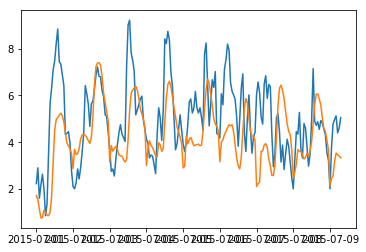

In [9]:
import matplotlib.pyplot as plt
plt.plot(data_merge['speed'][:200])
plt.plot(data_merge['speed_forecast'][:200])
plt.show()

In [8]:
print(mean_squared_error(data_merge['speed'], data_merge['speed_forecast']))
print(mean_absolute_error(data_merge['speed'], data_merge['speed_forecast']))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [27]:
X_train, X_test, y_train, y_test, X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled, sc_X, sc_y = scale_data_RNN(48, 48, df, 0.1, speed_only = True)

In [55]:
baseline = np.array(df['speed_forecast'][34144:])
baseline = baseline[:y_te.shape[0]]

In [56]:
baseline.shape

(3788,)

In [44]:
np.array(df['speed_forecast'])

array([1.71067229, 1.55361507, 1.13559172, ..., 6.47238627, 6.50744853,
       6.38456234])

In [29]:
def get_X_y(X_train, X_test, y_train, y_test, step2predict):
    X_t = X_train.reshape(X_train.shape[0],-1)
    X_te = X_test.reshape(X_test.shape[0],-1)
    #change 0 to 1 or 2 for cos_wind_dir or sin_wind_dir
    y_t = y_train[:,step2predict,0]
    y_te = y_test[:,step2predict,0]
    return X_t, X_te, y_t, y_te

In [30]:
X_t, X_te, y_t, y_te = get_X_y(X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled, 12)

In [70]:
xg = XGBRegressor(max_depth = 5)
xg.fit(X_t, y_t)
y_hat = xg.predict(X_te)
print(mean_squared_error(y_te, y_hat))
print(mean_absolute_error(y_te, y_hat))

/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[12:15:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9047207047514756
0.7525807462812547


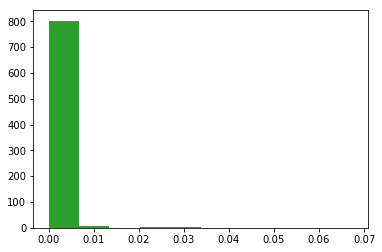

In [73]:
plt.hist(xg.feature_importances_)
plt.show()

2 max depth
1.0514130180673609
0.8285229944924967

3 max depth
0.9467532367134287
0.7795769491617314

4 max depth
0.9334842664915324
0.7690010867590146

5 max depth
0.9047207047514756
0.7525807462812547

In [66]:
xg.max_depth

3

In [58]:
print(mean_squared_error(y_te, y_hat))
print(mean_absolute_error(y_te, y_hat))
print(mean_squared_error(y_te, baseline))
print(mean_absolute_error(y_te, baseline))

0.9467532367134287
0.7795769491617314
1.8340037322247849
1.060940779149615


In [77]:
def get_all_prediction_models(steps_out):
    models = []
    maes = []
    mses = []
    y_hats = []
    X_train, X_test, y_train, y_test, X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled, sc_X, sc_y = scale_data_RNN(48, steps_out, df, 0.1, speed_only = True)
    for i in range(steps_out):
        X_t, X_te, y_t, y_te = get_X_y(X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled, i)
        xg = XGBRegressor(max_depth=5)
        xg.fit(X_t, y_t)
        y_hat = xg.predict(X_te)
        mse, mae = mean_squared_error(y_te, y_hat), mean_absolute_error(y_te, y_hat)
        print("MSE error for step ", i, " is: ", mse)
        print("MAE error for step ", i, " is: ", mae)
        maes.append(mae)
        mses.append(mse)
        models.append(xg)
        y_hats.append(y_hat)
    return models, maes, mses, y_hats

In [80]:
models, maes, mses, y_hats = get_all_prediction_models(48)

/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[13:12:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  0  is:  0.2949883505507611
MAE error for step  0  is:  0.4185583241256529


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[13:15:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  1  is:  0.4761080842992472
MAE error for step  1  is:  0.5482447603656712


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[13:19:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  2  is:  0.5713083349276342
MAE error for step  2  is:  0.6045320443090013


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[13:22:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  3  is:  0.6334330167710857
MAE error for step  3  is:  0.6376694523148819


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[13:25:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  4  is:  0.6778575119549028
MAE error for step  4  is:  0.6572384806204452


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[13:28:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  5  is:  0.7203678002420696
MAE error for step  5  is:  0.6774967491904449


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[13:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  6  is:  0.7519038057356864
MAE error for step  6  is:  0.6936767916222631


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[13:34:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  7  is:  0.7698781913854775
MAE error for step  7  is:  0.7003953435929503


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[13:37:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  8  is:  0.7939379194223072
MAE error for step  8  is:  0.7094229149033728


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[13:40:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  9  is:  0.8088375800693048
MAE error for step  9  is:  0.7149404857838981


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[13:43:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  10  is:  0.8168700119983605
MAE error for step  10  is:  0.7166729290828939


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[13:47:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  11  is:  0.842869615025888
MAE error for step  11  is:  0.7286025241355122


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[13:50:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  12  is:  0.9047207047514756
MAE error for step  12  is:  0.7525807462812547


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[13:53:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  13  is:  0.9620073571252663
MAE error for step  13  is:  0.7771868290531846


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[13:56:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  14  is:  1.0505351956568103
MAE error for step  14  is:  0.8138837493129738


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[13:59:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  15  is:  1.104166004154921
MAE error for step  15  is:  0.8307688325552274


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[14:02:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  16  is:  1.1362407080018841
MAE error for step  16  is:  0.8482478243504694


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[14:05:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  17  is:  1.1241950164481749
MAE error for step  17  is:  0.8469406491956772


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[14:08:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  18  is:  1.1680044730966959
MAE error for step  18  is:  0.8624021903068112


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[14:11:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  19  is:  1.2061651975853627
MAE error for step  19  is:  0.8742153328923199


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[14:14:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  20  is:  1.2234985279950195
MAE error for step  20  is:  0.8758574977008922


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[14:18:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  21  is:  1.2651144936760703
MAE error for step  21  is:  0.8909954188251304


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[14:21:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  22  is:  1.2497204111570357
MAE error for step  22  is:  0.8925628184669019


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[14:24:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  23  is:  1.3339885104930764
MAE error for step  23  is:  0.9189566591881413


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[14:27:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  24  is:  1.3809946522266012
MAE error for step  24  is:  0.9343316151753331


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[14:30:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  25  is:  1.419479533668145
MAE error for step  25  is:  0.9474810328674346


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[14:33:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  26  is:  1.4090006100572918
MAE error for step  26  is:  0.9456102996726953


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[14:36:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  27  is:  1.4487556201244094
MAE error for step  27  is:  0.963158417557133


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[14:39:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  28  is:  1.4972525020315017
MAE error for step  28  is:  0.9800066163535962


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[14:42:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  29  is:  1.471850514319492
MAE error for step  29  is:  0.9743700888686518


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[14:45:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  30  is:  1.4828178734208868
MAE error for step  30  is:  0.9803699965054142


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[14:48:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  31  is:  1.5424145203016104
MAE error for step  31  is:  1.0018483576609594


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[14:51:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  32  is:  1.548837176396926
MAE error for step  32  is:  1.0049384211076204


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[14:55:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  33  is:  1.546746909109885
MAE error for step  33  is:  1.0030070521216592


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[14:58:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  34  is:  1.5588944880782893
MAE error for step  34  is:  1.0068654559593693


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[15:01:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  35  is:  1.6095260700735463
MAE error for step  35  is:  1.0167521629099157


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[15:08:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  36  is:  1.6803094841375237
MAE error for step  36  is:  1.032239249932061


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[15:22:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  37  is:  1.650000803190019
MAE error for step  37  is:  1.0262071059630318


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[15:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  38  is:  1.6773531119780367
MAE error for step  38  is:  1.0317339230293552


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[15:35:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  39  is:  1.6802720851004036
MAE error for step  39  is:  1.0317502620890757


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[15:38:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  40  is:  1.7272811238530859
MAE error for step  40  is:  1.0437861142226388


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[15:40:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  41  is:  1.7721396207398918
MAE error for step  41  is:  1.050237959921624


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[15:43:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  42  is:  1.767826026998671
MAE error for step  42  is:  1.0532537637519925


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[15:46:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  43  is:  1.7607122054022646
MAE error for step  43  is:  1.0558203207248325


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[15:49:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  44  is:  1.8033847852332208
MAE error for step  44  is:  1.0636473242083582


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[15:51:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  45  is:  1.817950938125923
MAE error for step  45  is:  1.0722649080316757


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[15:54:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  46  is:  1.8298620648237496
MAE error for step  46  is:  1.0733401322876406


/Users/leobix/anaconda3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[15:57:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE error for step  47  is:  1.9124879371616736
MAE error for step  47  is:  1.0862594779487416


In [91]:
def get_forecasts(y_hats, y_te):
    forecasts = np.zeros((len(y_hats[0]), len(y_hats)))
    for i in range(len(y_hats[0])):
        for t in range(len(y_hats)):
            forecasts[i,t] = y_hats[t][i]
    return forecasts, y_te[:,:,0]

In [93]:
y_te.shape

(3788,)

In [94]:
forecasts, y_true = get_forecasts(y_hats, y_test_unscaled)

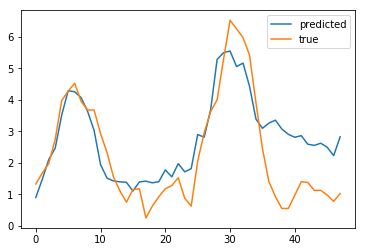

In [100]:
plt.plot(forecasts[2500], label = 'predicted')
plt.plot(y_true[2500], label = 'true')
plt.legend()
plt.show()

In [ ]:
def get_angle_in_degree(cos, sin):
    angle = 360*np.arccos(cos)/(2*np.pi)
    if sin >=0:
        angle +=180
    return angle

def test_angle(cos, sin):
    angle_cos = 360*np.arccos(cos)/(2*np.pi)
    if sin <=0:
        angle_cos +=180
    angle_sin = 360*np.arcsin(sin)/(2*np.pi)
    if cos <=0:
        angle_sin +=180
    return angle_cos, angle_sin   
    
def is_favorable(cos, sin):
    #angle is between NO and E
    angle = get_angle_in_degree(cos, sin)
    #NO
    if angle > 303.75:
        return True
    #under E
    elif angle < 101.25:
        return True
    return False

def is_South(cos, sin):
    angle = get_angle_in_degree(cos, sin)
    #Direction S, SSO, SSE
    if 146.25 <= angle <= 213.75:
        return True
    return False

In [ ]:
def is_S1(speed, cos, sin):
    if speed >= 4:
        return True
    elif speed > 1 and is_favorable(cos, sin):
        return True
    return False
    
def is_S2(speed, cos, sin):
    if 2 <= speed < 4 and not is_favorable(cos, sin):
        return True
    elif 0.5 <= speed <= 1 and is_favorable(cos, sin):
        return True
    return False
    
def is_S2b(speed, cos, sin):
    if 1<= speed <=2 and not is_favorable(cos, sin) and not is_South(cos, sin):
        return True
    return False

def is_S3(speed, cos, sin):
    if 0.5 <= speed < 1 and not is_favorable(cos, sin) and not is_South(cos, sin):
        return True
    elif speed < 0.5 and is_favorable(cos, sin):
        return True
    return False

def is_S3b(speed, cos, sin):
    if speed < 2 and is_South(cos, sin):
        return True
    return False

def is_S4(speed, cos, sin):
    if speed < 0.5 and not is_favorable(cos, sin):
        return True
    return False

def get_scenario(speed, cos, sin):
    if is_S1(speed, cos, sin):
        return 1
    elif is_S2(speed, cos, sin):
        return 2
    elif is_S2b(speed, cos, sin):
        return 2
    elif is_S3(speed, cos, sin):
        return 3
    elif is_S3b(speed, cos, sin):
        return 3
    elif is_S4(speed, cos, sin):
        return 4
    print("There is a problem.")
    print("speed: ", speed, " cos: ", cos, " sin: " sin)

In [2]:
import matplotlib.pyplot as plt
plt.plot(y_te[:200])
plt.plot(y_hat[:200])
plt.plot(baseline[:200])
plt.show()

NameError: name 'y_te' is not defined

In [41]:
def create_data_RNN(steps_in, steps_out, df):
    X, y = get_past_n_steps(df, steps_in), get_future_n_steps(df, steps_out)
    print(y)
    X2, y2 = np.array(X), np.array(y)
    X3, y3 = X2.reshape(-1, steps_in, X2.shape[1]//(steps_in)), y2.reshape(-1, steps_out, y2.shape[1]//(steps_out))
    y_from_X = X3[steps_in:-2*steps_in,:steps_out,:3]
    return y, X3[:y_from_X.shape[0]], y_from_X

In [46]:
e = t[['speed_t', 'cos_wind_dir_t', 'sin_wind_dir_t']]

In [30]:
def scale_data_RNN2(steps_in, steps_out, df, test_size = 0.2, speed_only = False):
    X, y = create_data_RNN(steps_in, steps_out, df)
    #y = y[:,:,:3]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle = False)
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    
    X_train2 = X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2])
    X_test2 = X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2])
    y_train2 = y_train.reshape(y_train.shape[0]*y_train.shape[1], y_train.shape[2])
    y_test2 = y_test.reshape(y_test.shape[0]*y_test.shape[1], y_test.shape[2])
    
    X_train_scaled = scaler_X.fit_transform(X_train2)
    X_test_scaled = scaler_X.transform(X_test2)
    y_train_scaled = scaler_y.fit_transform(y_train2)
    y_test_scaled = scaler_y.transform(y_test2)
    
    X_train_scaled = X_train_scaled.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    X_test_scaled = X_test_scaled.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
    y_train_scaled = y_train_scaled.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2])
    y_test_scaled = y_test_scaled.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2])
    
    X_train_final = X_train_scaled.transpose(0,1,2)
    X_test_final = X_test_scaled.transpose(0,1,2)
    y_train_final = y_train_scaled.transpose(0,1,2)
    y_test_final = y_test_scaled.transpose(0,1,2)

    if speed_only:
        print(y_train_final.shape)
        y_train_final = y_train_scaled[:,:,0]
        y_test_final = y_test_scaled[:,:,0]
    
    return y, X_train_final, X_test_final, y_train_final, y_test_final, y_train, y_test, scaler_X, scaler_y

In [31]:
y, X_train, X_test, y_train, y_test, y_train_unscaled, y_test_unscaled, sc_X, sc_y = scale_data_RNN2(48, 48, data_merge, 0.1, speed_only = True)

(37732, 48, 3)
(33958, 48, 3)


In [32]:
y

array([[[  0.   ,  44.25 ,   3.7  ],
        [  1.   ,  32.   ,   2.75 ],
        [  2.   ,  47.25 ,   2.85 ],
        ...,
        [ 21.   ,  28.5  ,   4.525],
        [ 22.   , 106.5  ,   5.175],
        [ 23.   ,  47.5  ,   4.525]],

       [[  1.   ,  32.   ,   2.75 ],
        [  2.   ,  47.25 ,   2.85 ],
        [  3.   ,  44.75 ,   2.55 ],
        ...,
        [ 22.   , 106.5  ,   5.175],
        [ 23.   ,  47.5  ,   4.525],
        [  0.   ,  60.25 ,   3.925]],

       [[  2.   ,  47.25 ,   2.85 ],
        [  3.   ,  44.75 ,   2.55 ],
        [  4.   ,  44.75 ,   3.275],
        ...,
        [ 23.   ,  47.5  ,   4.525],
        [  0.   ,  60.25 ,   3.925],
        [  1.   ,  41.   ,   3.6  ]],

       ...,

       [[ 21.   ,  93.25 ,   1.975],
        [ 22.   ,  94.25 ,   2.1  ],
        [ 23.   ,  99.   ,   1.4  ],
        ...,
        [ 18.   ,  39.75 ,   2.375],
        [ 19.   ,  75.   ,   2.75 ],
        [ 20.   ,  78.5  ,   3.1  ]],

       [[ 22.   ,  94.25 ,   2.1  ],
  

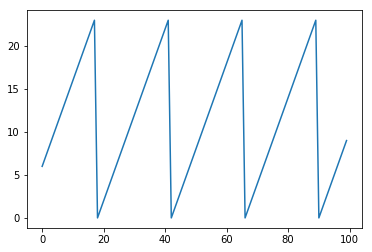

In [18]:
plt.plot(y_test_unscaled[:100,12,0])
#plt.plot(y_hat[:100])
plt.show()

In [7]:
steps_in = 48
steps_out = 48
test_size = 0.1

In [8]:
data=prepare_data(one_hot=False)
#data_merge = prepare_data_with_forecast(data)
data_merge, data, forecast  = prepare_data_with_forecast(data)
   #data_merge.to_csv('training_data.csv', index = True)
   #data_merge = read_csv("training_data.csv", index_col=0)
   #print(data_merge)
df = data_merge[['speed', 'cos_wind_dir', 'sin_wind_dir', 'temp', 'radiation', 'scenario_num', 'cos_hour', 'sin_hour', 'cos_day', 'sin_day', 'daily_min_speed', 'daily_min_hour', 'daily_max_speed', 'daily_max_hour', 'speed_forecast', 'cos_wind_dir_forecast', 'sin_wind_dir_forecast']]

print("Data has been processed and merged.")
X_train, X_test, y_train, y_test, X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled, sc_X, sc_y = scale_data_RNN(steps_in, steps_out, df, test_size=test_size, speed_only = True)

read csv semester csv files from 2015s2 to 2019s2
smooth wind direction
smooth hour
smooth day
generate daily features: ['daily_min_speed', 'daily_min_hour', 'daily_max_speed', 'daily_max_hour']
generate seasonality categorical feature
generate day/night categorical feature
reading forecast data


/Users/leobix/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


keep last forecast, duplicates dropped =  96574
smooth wind direction
merge with forecast data
Data has been processed and merged.


In [10]:
y_train_unscaled

array([[[3.7       , 0.7127612 , 0.69452034],
        [2.75      , 0.8465571 , 0.52900168],
        [2.85      , 0.66830943, 0.72344977],
        ...,
        [4.525     , 0.87250044, 0.47343036],
        [5.175     , 0.92945321, 0.27531659],
        [4.525     , 0.6606555 , 0.72165574]],

       [[2.75      , 0.8465571 , 0.52900168],
        [2.85      , 0.66830943, 0.72344977],
        [2.55      , 0.70554391, 0.69947487],
        ...,
        [5.175     , 0.92945321, 0.27531659],
        [4.525     , 0.6606555 , 0.72165574],
        [3.925     , 0.48275046, 0.84469968]],

       [[2.85      , 0.66830943, 0.72344977],
        [2.55      , 0.70554391, 0.69947487],
        [3.275     , 0.7065119 , 0.70022896],
        ...,
        [4.525     , 0.6606555 , 0.72165574],
        [3.925     , 0.48275046, 0.84469968],
        [3.6       , 0.75153837, 0.65332872]],

       ...,

       [[5.075     , 0.57519685, 0.81369969],
        [4.4       , 0.69477122, 0.71336488],
        [4.35      , 0